In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import types as T

import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def rename_columns(df, list_of_tuples):
    for (old_col, new_col) in list_of_tuples:
        df = df.withColumnRenamed(old_col, new_col)
    return df

def read_hdfs_folder(sqlContext, folderpath):
    data_frame = sqlContext.read.format("com.databricks.spark.csv")\
        .option("header", "true")\
        .option("inferSchema", "true") \
        .option("nullValue", "-")\
        .load(folderpath)
        
    data_frame = rename_columns(
        data_frame,
        [
            ("cardNum18", "cardNum"),
            ("cardNum19", "userGender"),
        ]
    )
    
    date = "-".join(folderpath.split("/")[-2].split("_")[:3])

    data_frame = data_frame.withColumn("date", F.lit(date))
    data_frame = data_frame.withColumn("date", F.date_sub(F.col("date"),1))

    return data_frame

def read_buste_data_v3(sqlContext, filepath):
    data_frame = sqlContext.read.csv(filepath, header=True,
                                     inferSchema=True,nullValue="-")
    
    date = "-".join(filepath.split("/")[-2].split("_")[:3])

    data_frame = data_frame.withColumn("date", F.lit(date))
    data_frame = data_frame.withColumn("date", F.unix_timestamp(F.date_sub(F.col("date"),1),'yyyy-MM-dd'))
    
    return data_frame

def printdf(df,l=10):
    return df.limit(l).toPandas()

### Read BUSTE result Data

In [3]:
sc = SparkContext.getOrCreate()
sqlContext = pyspark.SQLContext(sc)

In [4]:
exp_data_folder_path = '/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-data/bulma-test/'

In [5]:
user_boardings = read_hdfs_folder(sqlContext, exp_data_folder_path + '/bulma-output/2017_05_11_veiculos.csv/')

In [6]:
printdf(user_boardings)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,userGender,date
0,673,12,2138,3971706,-25.485661,-49.292333,2874.405,HN607,None,NaN,...,NaN,12:00:26,32149,BETWEEN,None,None,None,None,None,2017-05-10
1,673,12,2138,3971716,-25.481877,-49.290882,3321.774,HN607,None,NaN,...,NaN,12:01:23,32147,BETWEEN,None,None,None,None,None,2017-05-10
2,673,12,2138,3971729,-25.477864,-49.289402,3804.620,HN607,None,NaN,...,NaN,12:02:04,32144,BETWEEN,None,None,None,None,None,2017-05-10
3,673,12,2138,3971751,-25.473048,-49.290543,4377.673,HN607,None,NaN,...,NaN,12:02:59,32143,BETWEEN,None,None,None,None,None,2017-05-10
4,673,12,2138,3971764,-25.470706,-49.290943,4648.310,HN607,None,-25.47058,...,16.97322,12:03:29,32125,NO_PROBLEM,None,None,None,None,None,2017-05-10
5,673,12,2138,3971771,-25.468631,-49.289973,4898.042,HN607,None,NaN,...,NaN,12:04:33,32122,BETWEEN,None,None,None,None,None,2017-05-10
6,673,12,2138,3971796,-25.463906,-49.289532,5455.881,HN607,None,NaN,...,NaN,12:05:28,32119,BETWEEN,None,None,None,None,None,2017-05-10
7,673,12,2138,3971805,-25.461175,-49.288261,5784.354,HN607,None,NaN,...,NaN,12:06:02,32118,BETWEEN,None,None,None,None,None,2017-05-10
8,673,12,2138,3971812,-25.459527,-49.287460,5983.858,HN607,None,NaN,...,NaN,12:06:23,32115,BETWEEN,None,None,None,None,None,2017-05-10
9,673,12,2138,3971826,-25.455668,-49.285611,6450.129,HN607,None,NaN,...,NaN,12:08:04,32114,BETWEEN,None,None,None,None,None,2017-05-10


In [7]:
user_boardings.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- cardNum: integer (nullable = true)
 |-- userGender: string (nullable = true)
 |-- date: date (nullable = true)



In [8]:
total_boardings = user_boardings.count()
print total_boardings

60979


In [9]:
total_passengers = user_boardings.select('cardNum').distinct().count()
print total_passengers

9464


### Removing rows with missing data

In [10]:
filtered_boardings = user_boardings.na.drop(subset=["route","busCode","tripNum","stopPointId","timestamp","shapeLon","shapeLat","cardNum","cardTimestamp"])

In [11]:
total_filtered_boardings = filtered_boardings.count()
print total_filtered_boardings, "(", 100*(total_filtered_boardings/float(total_boardings)), "%)"
printdf(filtered_boardings)

10855 ( 17.8012102527 %)


,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,userGender,date
0,826,7,2944,4239726,-25.512522,-49.330196,630.493,LA011,None,-25.512561,...,11.882569,12:03:02,35108,NO_PROBLEM,19/09/80,12:03:43,C.COMPRIDO/CIC,2337836,F,2017-05-10
1,826,7,2944,4239726,-25.512522,-49.330196,630.493,LA011,None,-25.512561,...,11.882569,12:03:02,35108,NO_PROBLEM,02/01/89,12:03:54,C.COMPRIDO/CIC,3697996,M,2017-05-10
2,826,7,2944,4239772,-25.512820,-49.337522,1633.259,LA011,None,NaN,...,NaN,12:07:02,33218,BETWEEN,23/01/97,12:07:05,C.COMPRIDO/CIC,3458749,F,2017-05-10
3,826,7,2944,4239837,-25.497124,-49.342234,3441.838,LA011,None,-25.497006,...,13.197079,12:10:49,33210,NO_PROBLEM,08/03/00,12:11:39,C.COMPRIDO/CIC,3728358,M,2017-05-10
4,826,7,2944,4239895,-25.485742,-49.346577,4779.351,LA011,None,NaN,...,NaN,12:14:43,33204,BETWEEN,06/05/97,12:14:48,C.COMPRIDO/CIC,3760162,M,2017-05-10
5,826,7,2944,4239991,-25.473855,-49.351779,6860.096,LA011,None,-25.473970,...,15.580649,12:21:11,33196,NO_PROBLEM,01/10/94,12:21:32,C.COMPRIDO/CIC,3647844,M,2017-05-10
6,826,7,2944,4239991,-25.473855,-49.351779,6860.096,LA011,None,-25.473970,...,15.580649,12:21:11,33196,NO_PROBLEM,28/07/89,12:22:09,C.COMPRIDO/CIC,3272708,F,2017-05-10
7,826,7,2944,4239991,-25.473855,-49.351779,6860.096,LA011,None,-25.473970,...,15.580649,12:21:11,33196,NO_PROBLEM,17/05/00,12:21:38,C.COMPRIDO/CIC,3805349,M,2017-05-10
8,826,7,2944,4240097,-25.451799,-49.361993,9514.394,LA011,None,NaN,...,NaN,12:26:48,33186,BETWEEN,18/07/98,12:27:37,C.COMPRIDO/CIC,3715968,M,2017-05-10
9,826,7,2944,4240125,-25.450401,-49.354248,10339.848,LA011,None,-25.450490,...,22.593756,12:29:14,34469,NO_PROBLEM,03/05/00,12:31:35,C.COMPRIDO/CIC,3685757,F,2017-05-10


### Removing duplicated passenger data

In [12]:
filtered_boardings = filtered_boardings.dropDuplicates(['cardNum','date','cardTimestamp'])

In [13]:
non_duplicated_boardings = filtered_boardings.count()
print non_duplicated_boardings, "(", 100*(non_duplicated_boardings/float(total_boardings)), "%)"
printdf(filtered_boardings)

10855 ( 17.8012102527 %)


,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,userGender,date
0,547,15,4125,6165607,-25.541827,-49.264612,4097.772,GA142,None,-25.541680,...,31.689760,05:53:33,31271,NO_PROBLEM,22/04/63,05:54:23,V. SÃO PEDRO,431802,F,2017-05-10
1,628,2,2055,6035022,-25.544264,-49.315882,11215.314,HA016,None,-25.544026,...,40.477060,07:59:07,35163,NO_PROBLEM,06/03/89,07:59:30,CARBOMAFRA,768474,F,2017-05-10
2,637,18,2071,6489450,-25.537563,-49.276767,1176.369,GA157,None,-25.537596,...,21.741392,14:23:07,29981,NO_PROBLEM,10/02/82,14:23:56,STA. JOANA,1130949,F,2017-05-10
3,916,1,2273,4159111,-25.381888,-49.334432,1373.961,MA002,None,-25.381835,...,7.854279,06:36:34,33426,NO_PROBLEM,08/07/62,06:36:43,PINHEIROS,1243075,F,2017-05-10
4,646,1,3100,5567669,-25.586906,-49.322500,10113.406,HA606,None,-25.586931,...,9.722615,05:15:51,39990,NO_PROBLEM,06/03/81,05:25:39,RIO BONITO,1593423,F,2017-05-10
5,475,10,2876,6361693,-25.444563,-49.259533,2154.179,EC301,None,-25.444698,...,15.032312,18:10:07,32138,NO_PROBLEM,29/09/83,18:10:12,CANAL BELÉM,1614005,M,2017-05-10
6,655,1,2109,4071668,-25.567660,-49.322338,3237.234,HA001,None,NaN,...,NaN,05:26:06,39266,BETWEEN,28/01/60,05:26:26,JD. ORDEM,1649670,F,2017-05-10
7,475,2,2876,6361621,-25.435167,-49.271767,0.000,EC304,None,-25.435111,...,8.100565,06:42:10,26174,NO_PROBLEM,23/04/82,06:44:35,CANAL BELÉM,1844650,M,2017-05-10
8,547,21,4125,6165607,-25.541827,-49.264612,4097.772,GA142,None,-25.541718,...,28.093569,07:36:05,31271,NO_PROBLEM,13/07/86,07:36:14,V. SÃO PEDRO,1897009,M,2017-05-10
9,628,9,2935,6035469,-25.504465,-49.317804,11208.115,HA025,None,-25.504488,...,6.691033,16:19:21,35098,NO_PROBLEM,02/06/87,16:19:36,CARBOMAFRA,2010812,M,2017-05-10


### Removing single-trip users records

In [14]:
boarding_count = filtered_boardings.groupby('cardNum').count()

In [15]:
#Filtering only users with more than one ride per day
multiple_boardings = boarding_count.filter(F.col('count') > 1)

In [16]:
total_passengers = user_boardings.select('cardNum').distinct().count()
print "Total #Passengers:", total_passengers

Total #Passengers: 9464


In [17]:
passengers_mult_boardings = multiple_boardings.count()
prop_mult_boardings = 100*(passengers_mult_boardings)/total_passengers
print "Passengers with Multiple Boardings:", passengers_mult_boardings, "(", prop_mult_boardings, "%)" 
multiple_boardings.show()

Passengers with Multiple Boardings: 1221 ( 12 %)
+-------+-----+
|cardNum|count|
+-------+-----+
|3553903|    2|
|2570449|    2|
|3414874|    3|
|3218257|    2|
|3606134|    2|
|3773168|    2|
| 963702|    4|
|3522037|    2|
|2937047|    2|
|1722545|    2|
|3635001|    2|
|2194392|    2|
|3808146|    2|
|2251765|    2|
|1699409|    2|
|3803970|    2|
|1607186|    2|
|2914899|    2|
|3786350|    2|
|3664725|    3|
+-------+-----+
only showing top 20 rows



In [18]:
multiple_boardings = multiple_boardings.select(F.col("cardNum").alias("cardNum1"),
                                                 F.col("count").alias("count1"))

In [19]:
clean_boardings = filtered_boardings.join(multiple_boardings, filtered_boardings.cardNum == multiple_boardings.cardNum1, 'leftsemi')

In [20]:
clean_boardings.count()

2613

In [21]:
printdf(clean_boardings)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,userGender,date
0,628,9,2935,6035469,-25.504465,-49.317804,11208.115,HA025,None,-25.504488,...,6.691033,16:19:21,35098,NO_PROBLEM,02/06/87,16:19:36,CARBOMAFRA,2010812,M,2017-05-10
1,475,10,2876,6361668,-25.442023,-49.264025,1415.894,EC303,None,NaN,...,NaN,18:25:01,32670,BETWEEN,22/04/78,18:25:03,CANAL BELÉM,2271310,M,2017-05-10
2,646,4,3100,5567663,-25.586374,-49.320862,9938.586,HA603,None,-25.586385,...,11.418673,17:25:09,39988,NO_PROBLEM,05/07/65,17:25:14,POMPÉIA / JANAÍNA,2342964,M,2017-05-10
3,628,2,2935,6035156,-25.546783,-49.336131,983.694,HA025,None,NaN,...,NaN,06:31:56,35192,BETWEEN,31/07/91,06:31:59,CARBOMAFRA,2358587,M,2017-05-10
4,655,1,2108,4072909,-25.559791,-49.328399,9890.159,HA256,None,-25.559611,...,20.052725,07:31:52,39273,NO_PROBLEM,25/09/76,07:32:12,OP. CONTIGENCIA,2550425,F,2017-05-10
5,222,3,1794,6250169,-25.383227,-49.200293,5505.041,BA029,None,-25.383250,...,8.118075,07:42:34,34826,NO_PROBLEM,02/01/90,07:42:55,V. ESPERANÇA,3589264,F,2017-05-10
6,673,5,2137,6043635,-25.444555,-49.275626,1331.886,HN615,None,NaN,...,NaN,11:05:41,32099,BETWEEN,13/12/86,11:05:56,FORMOSA,3625439,M,2017-05-10
7,60,7,1721,4390027,-25.526520,-49.328950,12054.335,HB603,None,-25.526560,...,5.267060,17:47:53,33235,NO_PROBLEM,10/11/57,17:48:51,INTERBAIRROS VI,3632693,F,2017-05-10
8,475,2,1938,6361322,-25.478307,-49.240389,4657.229,EC303,None,-25.478300,...,8.628957,07:16:10,33491,NO_PROBLEM,17/10/08,07:16:50,OP. CONTIGENCIA,3829606,F,2017-05-10
9,655,5,2109,4071589,-25.560278,-49.336814,1507.314,HA257,None,-25.560401,...,25.620853,08:56:11,39331,NO_PROBLEM,29/10/71,08:56:18,JD. ORDEM,963702,F,2017-05-10


In [22]:
clean_boardings.write.csv(path=exp_data_folder_path+'/clean_boardings',header=True, mode='overwrite')

### Analyzing Boarding data

In [23]:
boarding_data = clean_boardings.withColumn('boarding_id',F.monotonically_increasing_id())
printdf(boarding_data)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,userGender,date,boarding_id
0,628,9,2935,6035469,-25.504465,-49.317804,11208.115,HA025,None,-25.504488,...,16:19:21,35098,NO_PROBLEM,02/06/87,16:19:36,CARBOMAFRA,2010812,M,2017-05-10,0
1,475,10,2876,6361668,-25.442023,-49.264025,1415.894,EC303,None,NaN,...,18:25:01,32670,BETWEEN,22/04/78,18:25:03,CANAL BELÉM,2271310,M,2017-05-10,1
2,646,4,3100,5567663,-25.586374,-49.320862,9938.586,HA603,None,-25.586385,...,17:25:09,39988,NO_PROBLEM,05/07/65,17:25:14,POMPÉIA / JANAÍNA,2342964,M,2017-05-10,2
3,628,2,2935,6035156,-25.546783,-49.336131,983.694,HA025,None,NaN,...,06:31:56,35192,BETWEEN,31/07/91,06:31:59,CARBOMAFRA,2358587,M,2017-05-10,3
4,655,1,2108,4072909,-25.559791,-49.328399,9890.159,HA256,None,-25.559611,...,07:31:52,39273,NO_PROBLEM,25/09/76,07:32:12,OP. CONTIGENCIA,2550425,F,2017-05-10,4
5,222,3,1794,6250169,-25.383227,-49.200293,5505.041,BA029,None,-25.383250,...,07:42:34,34826,NO_PROBLEM,02/01/90,07:42:55,V. ESPERANÇA,3589264,F,2017-05-10,5
6,673,5,2137,6043635,-25.444555,-49.275626,1331.886,HN615,None,NaN,...,11:05:41,32099,BETWEEN,13/12/86,11:05:56,FORMOSA,3625439,M,2017-05-10,6
7,60,7,1721,4390027,-25.526520,-49.328950,12054.335,HB603,None,-25.526560,...,17:47:53,33235,NO_PROBLEM,10/11/57,17:48:51,INTERBAIRROS VI,3632693,F,2017-05-10,7
8,475,2,1938,6361322,-25.478307,-49.240389,4657.229,EC303,None,-25.478300,...,07:16:10,33491,NO_PROBLEM,17/10/08,07:16:50,OP. CONTIGENCIA,3829606,F,2017-05-10,8
9,655,5,2109,4071589,-25.560278,-49.336814,1507.314,HA257,None,-25.560401,...,08:56:11,39331,NO_PROBLEM,29/10/71,08:56:18,JD. ORDEM,963702,F,2017-05-10,8589934592


In [24]:
user_boarding_w = Window.partitionBy(boarding_data.cardNum, boarding_data.date).orderBy(boarding_data.cardTimestamp)
od_matrix_ids = boarding_data.select(F.col('cardNum'),
                     F.col('boarding_id'), 
                     F.lead('boarding_id',default=-1).over(user_boarding_w).alias('next_boarding_id'),
                     F.first('boarding_id',True).over(user_boarding_w).alias('first_boarding')) \
                    .withColumn('next_boarding_id', 
                         F.when(F.col('next_boarding_id') == -1,F.col('first_boarding')). \
                                         otherwise(F.col('next_boarding_id'))).drop('first_boarding')

printdf(od_matrix_ids)

,cardNum,boarding_id,next_boarding_id
0,1650119,678604832779,670014898188
1,1650119,670014898188,678604832779
2,2104801,566935683085,884763262984
3,2104801,884763262984,566935683085
4,2259079,1700807049230,1262720385032
5,2259079,1262720385032,1700807049230
6,2291767,180388626434,962072674307
7,2291767,962072674307,180388626434
8,3336625,609885356045,498216206353
9,3336625,498216206353,1314259992587


In [25]:
boarding_data.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- cardNum: integer (nullable = true)
 |-- userGender: string (nullable = true)
 |-- date: date (nullable = true)
 |-- boarding_id: long (nullable = false)



In [26]:
origin_matrix = boarding_data.select(F.col("route").alias("o_route"),
                                    F.col("busCode").alias("o_bus_code"),
                                    F.col("date").alias("o_date"),
                                    F.col("tripNum").alias("o_tripNum"),
                                    F.col("cardTimestamp").alias("o_timestamp"),
                                    F.col("shapeId").alias("o_shape_id"),
                                    F.col("shapeSequence").alias("o_shape_seq"),
                                    F.col("shapeLat").alias("o_shape_lat"),
                                    F.col("shapeLon").alias("o_shape_lon"),
                                    F.col("stopPointId").alias("o_stop_id"),
                                    F.col("boarding_id").alias("o_boarding_id"))

In [27]:
next_origin_matrix = boarding_data.select(F.col("route").alias("next_o_route"),
                                    F.col("busCode").alias("next_o_bus_code"),
                                    F.col("date").alias("next_o_date"),
                                    F.col("tripNum").alias("next_o_tripNum"),
                                    F.col("cardTimestamp").alias("next_o_timestamp"),
                                    F.col("shapeId").alias("next_o_shape_id"),
                                    F.col("shapeSequence").alias("next_o_shape_seq"),
                                    F.col("shapeLat").alias("next_o_shape_lat"),
                                    F.col("shapeLon").alias("next_o_shape_lon"),
                                    F.col("stopPointId").alias("next_o_stop_id"),
                                    F.col("boarding_id").alias("next_o_boarding_id"))

In [28]:
printdf(origin_matrix)

,o_route,o_bus_code,o_date,o_tripNum,o_timestamp,o_shape_id,o_shape_seq,o_shape_lat,o_shape_lon,o_stop_id,o_boarding_id
0,628,HA025,2017-05-10,9,16:19:36,2935,6035469,-25.504465,-49.317804,35098,0
1,475,EC303,2017-05-10,10,18:25:03,2876,6361668,-25.442023,-49.264025,32670,1
2,646,HA603,2017-05-10,4,17:25:14,3100,5567663,-25.586374,-49.320862,39988,2
3,628,HA025,2017-05-10,2,06:31:59,2935,6035156,-25.546783,-49.336131,35192,3
4,655,HA256,2017-05-10,1,07:32:12,2108,4072909,-25.559791,-49.328399,39273,4
5,222,BA029,2017-05-10,3,07:42:55,1794,6250169,-25.383227,-49.200293,34826,5
6,673,HN615,2017-05-10,5,11:05:56,2137,6043635,-25.444555,-49.275626,32099,6
7,60,HB603,2017-05-10,7,17:48:51,1721,4390027,-25.526520,-49.328950,33235,7
8,475,EC303,2017-05-10,2,07:16:50,1938,6361322,-25.478307,-49.240389,33491,8
9,655,HA257,2017-05-10,5,08:56:18,2109,4071589,-25.560278,-49.336814,39331,8589934592


In [29]:
printdf(next_origin_matrix)

,next_o_route,next_o_bus_code,next_o_date,next_o_tripNum,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id
0,628,HA025,2017-05-10,9,16:19:36,2935,6035469,-25.504465,-49.317804,35098,0
1,475,EC303,2017-05-10,10,18:25:03,2876,6361668,-25.442023,-49.264025,32670,1
2,646,HA603,2017-05-10,4,17:25:14,3100,5567663,-25.586374,-49.320862,39988,2
3,628,HA025,2017-05-10,2,06:31:59,2935,6035156,-25.546783,-49.336131,35192,3
4,655,HA256,2017-05-10,1,07:32:12,2108,4072909,-25.559791,-49.328399,39273,4
5,222,BA029,2017-05-10,3,07:42:55,1794,6250169,-25.383227,-49.200293,34826,5
6,673,HN615,2017-05-10,5,11:05:56,2137,6043635,-25.444555,-49.275626,32099,6
7,60,HB603,2017-05-10,7,17:48:51,1721,4390027,-25.526520,-49.328950,33235,7
8,475,EC303,2017-05-10,2,07:16:50,1938,6361322,-25.478307,-49.240389,33491,8
9,655,HA257,2017-05-10,5,08:56:18,2109,4071589,-25.560278,-49.336814,39331,8589934592


In [31]:
user_trips = origin_matrix.join(od_matrix_ids, 
                                        origin_matrix.o_boarding_id == od_matrix_ids.boarding_id, 'inner') \
                                    .join(next_origin_matrix, od_matrix_ids.next_boarding_id == next_origin_matrix.next_o_boarding_id, 'inner') \
                                    .drop('boarding_id') \
                                    .drop('next_boarding_id')

In [32]:
user_trips.columns

['o_route',
 'o_bus_code',
 'o_date',
 'o_tripNum',
 'o_timestamp',
 'o_shape_id',
 'o_shape_seq',
 'o_shape_lat',
 'o_shape_lon',
 'o_stop_id',
 'o_boarding_id',
 'cardNum',
 'next_o_route',
 'next_o_bus_code',
 'next_o_date',
 'next_o_tripNum',
 'next_o_timestamp',
 'next_o_shape_id',
 'next_o_shape_seq',
 'next_o_shape_lat',
 'next_o_shape_lon',
 'next_o_stop_id',
 'next_o_boarding_id']

In [33]:
printdf(user_trips)

,o_route,o_bus_code,o_date,o_tripNum,o_timestamp,o_shape_id,o_shape_seq,o_shape_lat,o_shape_lon,o_stop_id,...,next_o_bus_code,next_o_date,next_o_tripNum,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id
0,628,HA025,2017-05-10,9,16:19:36,2935,6035469,-25.504465,-49.317804,35098,...,HA256,2017-05-10,1,07:32:08,2108,4072909,-25.559791,-49.328399,39273,1374389534722
1,475,EC303,2017-05-10,10,18:25:03,2876,6361668,-25.442023,-49.264025,32670,...,HA265,2017-05-10,7,12:16:08,2040,6140463,-25.525286,-49.330053,33233,764504178691
2,646,HA603,2017-05-10,4,17:25:14,3100,5567663,-25.586374,-49.320862,39988,...,EC301,2017-05-10,2,06:52:31,1938,6361198,-25.495564,-49.224429,33550,171798691850
3,628,HA025,2017-05-10,2,06:31:59,2935,6035156,-25.546783,-49.336131,35192,...,EC301,2017-05-10,9,16:34:40,1938,6361620,-25.435197,-49.271753,26174,146028888079
4,655,HA256,2017-05-10,1,07:32:12,2108,4072909,-25.559791,-49.328399,39273,...,DA016,2017-05-10,1,05:04:33,2945,5578633,-25.449886,-49.204456,35464,128849018889
5,222,BA029,2017-05-10,3,07:42:55,1794,6250169,-25.383227,-49.200293,34826,...,HA016,2017-05-10,3,09:24:00,2055,6035105,-25.548866,-49.342243,35184,420906795010
6,673,HN615,2017-05-10,5,11:05:56,2137,6043635,-25.444555,-49.275626,32099,...,HR120,2017-05-10,3,17:10:12,1722,4392366,-25.525956,-49.297618,33281,25769803779
7,60,HB603,2017-05-10,7,17:48:51,1721,4390027,-25.526520,-49.328950,33235,...,GA142,2017-05-10,20,07:15:47,4125,6165566,-25.536810,-49.255871,37147,120259084302
8,475,EC303,2017-05-10,2,07:16:50,1938,6361322,-25.478307,-49.240389,33491,...,EC013,2017-05-10,7,14:01:57,2876,6361934,-25.478424,-49.240293,33489,1468878815241
9,655,HA257,2017-05-10,5,08:56:18,2109,4071589,-25.560278,-49.336814,39331,...,HA004,2017-05-10,7,15:16:34,2040,6140331,-25.548642,-49.324879,35171,60129542144


In [34]:
printdf(user_trips.select(['cardNum','o_route','o_bus_code','o_timestamp','o_stop_id','next_o_route','next_o_bus_code','next_o_timestamp','next_o_stop_id']).
        orderBy(['cardNum','o_timestamp',]), l=30)

,cardNum,o_route,o_bus_code,o_timestamp,o_stop_id,next_o_route,next_o_bus_code,next_o_timestamp,next_o_stop_id
0,559872,475,EC013,12:20:57,30749,673,HN615,14:42:38,8129
1,559872,673,HN615,14:42:38,8129,475,EC013,12:20:57,30749
2,623748,916,MA007,11:04:37,33126,916,MA002,13:15:04,33341
3,623748,916,MA002,13:15:04,33341,916,MA007,11:04:37,33126
4,625642,718,JA015,06:43:47,35497,826,LA004,18:04:54,33187
5,625642,826,LA004,18:04:54,33187,718,JA015,06:43:47,35497
6,717157,646,HA606,06:32:53,39990,475,EC304,14:47:25,32138
7,717157,475,EC304,14:47:25,32138,646,HA606,06:32:53,39990
8,746934,916,MA007,08:21:48,33433,628,HA016,16:09:52,38380
9,746934,628,HA016,16:09:52,38380,916,MA007,08:21:48,33433


In [35]:
user_trips.count()

2613

In [36]:
user_trips = user_trips.withColumn('o_unixtimestamp',F.unix_timestamp(F.col('o_timestamp'), 'HH:mm:ss')) \
                                        .withColumn('next_o_unixtimestamp',F.unix_timestamp(F.col('next_o_timestamp'), 'HH:mm:ss'))
                                        

In [37]:
printdf(user_trips)

,o_route,o_bus_code,o_date,o_tripNum,o_timestamp,o_shape_id,o_shape_seq,o_shape_lat,o_shape_lon,o_stop_id,...,next_o_tripNum,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp
0,628,HA025,2017-05-10,9,16:19:36,2935,6035469,-25.504465,-49.317804,35098,...,1,07:32:08,2108,4072909,-25.559791,-49.328399,39273,1374389534722,69576,37928
1,475,EC303,2017-05-10,10,18:25:03,2876,6361668,-25.442023,-49.264025,32670,...,7,12:16:08,2040,6140463,-25.525286,-49.330053,33233,764504178691,77103,54968
2,646,HA603,2017-05-10,4,17:25:14,3100,5567663,-25.586374,-49.320862,39988,...,2,06:52:31,1938,6361198,-25.495564,-49.224429,33550,171798691850,73514,35551
3,628,HA025,2017-05-10,2,06:31:59,2935,6035156,-25.546783,-49.336131,35192,...,9,16:34:40,1938,6361620,-25.435197,-49.271753,26174,146028888079,34319,70480
4,655,HA256,2017-05-10,1,07:32:12,2108,4072909,-25.559791,-49.328399,39273,...,1,05:04:33,2945,5578633,-25.449886,-49.204456,35464,128849018889,37932,29073
5,222,BA029,2017-05-10,3,07:42:55,1794,6250169,-25.383227,-49.200293,34826,...,3,09:24:00,2055,6035105,-25.548866,-49.342243,35184,420906795010,38575,44640
6,673,HN615,2017-05-10,5,11:05:56,2137,6043635,-25.444555,-49.275626,32099,...,3,17:10:12,1722,4392366,-25.525956,-49.297618,33281,25769803779,50756,72612
7,60,HB603,2017-05-10,7,17:48:51,1721,4390027,-25.526520,-49.328950,33235,...,20,07:15:47,4125,6165566,-25.536810,-49.255871,37147,120259084302,74931,36947
8,475,EC303,2017-05-10,2,07:16:50,1938,6361322,-25.478307,-49.240389,33491,...,7,14:01:57,2876,6361934,-25.478424,-49.240293,33489,1468878815241,37010,61317
9,655,HA257,2017-05-10,5,08:56:18,2109,4071589,-25.560278,-49.336814,39331,...,7,15:16:34,2040,6140331,-25.548642,-49.324879,35171,60129542144,42978,65794


In [38]:
user_trips = user_trips.withColumn('leg_duration',
                                                   F.when(F.col('next_o_unixtimestamp') > F.col('o_unixtimestamp'),
                                                       ((F.col('next_o_unixtimestamp') - F.col('o_unixtimestamp'))/60.0)). \
                                                   otherwise(-1))                                        

In [39]:
printdf(user_trips.select(['cardNum','o_timestamp','o_unixtimestamp','next_o_timestamp','next_o_unixtimestamp','leg_duration']),l=30)

,cardNum,o_timestamp,o_unixtimestamp,next_o_timestamp,next_o_unixtimestamp,leg_duration
0,2550425,07:32:12,37932,07:32:08,37928,-1.000000
1,2358587,06:31:59,34319,12:16:08,54968,344.150000
2,2010812,16:19:36,69576,05:48:20,31700,-1.000000
3,3625439,11:05:56,50756,07:15:05,36905,-1.000000
4,3589264,07:42:55,38575,17:12:33,72753,569.633333
5,3829606,07:16:50,37010,09:11:05,43865,114.250000
6,2271310,18:25:03,77103,06:18:18,33498,-1.000000
7,3632693,17:48:51,74931,17:48:48,74928,-1.000000
8,2342964,17:25:14,73514,06:16:58,33418,-1.000000
9,3773061,07:15:50,36950,07:16:00,36960,0.166667


In [40]:
printdf(user_trips.filter('leg_duration < -1 or leg_duration > 15').describe(['leg_duration']))

,summary,leg_duration
0,count,766
1,mean,432.8278067885116
2,stddev,218.58110868340464
3,min,15.15
4,max,869.1333333333333


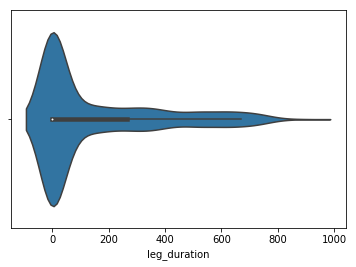

In [63]:
sns.violinplot(x=user_trips.toPandas()["leg_duration"])

In [41]:
user_trips.filter('leg_duration > 0').approxQuantile("leg_duration", [0.5], 0)

[86.7]

In [42]:
user_trips.write.csv(exp_data_folder_path + '/user_trips', header=True, mode='overwrite')

### Infer Destination Stops

In [43]:
user_trips_data = user_trips \
                .withColumn('o_date',F.from_unixtime(F.unix_timestamp(F.col('o_date'),'yyyy-MM-dd'), 'yyyy-MM-dd')) \
                .withColumn('next_o_date',F.from_unixtime(F.unix_timestamp(F.col('next_o_date'),'yyyy-MM-dd'), 'yyyy-MM-dd')) \
                .orderBy(['cardNum','o_date','o_timestamp'])

In [44]:
printdf(user_trips_data)

,o_route,o_bus_code,o_date,o_tripNum,o_timestamp,o_shape_id,o_shape_seq,o_shape_lat,o_shape_lon,o_stop_id,...,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration
0,475,EC013,2017-05-10,6,12:20:57,1938,6361589,-25.436050,-49.266952,30749,...,14:42:38,2138,3971657,-25.492666,-49.312509,8129,68719476742,55257,63758,141.683333
1,673,HN615,2017-05-10,8,14:42:38,2138,3971657,-25.492666,-49.312509,8129,...,12:20:57,1938,6361589,-25.436050,-49.266952,30749,1288490188817,63758,55257,-1.000000
2,916,MA007,2017-05-10,5,11:04:37,2273,4159214,-25.400920,-49.330158,33126,...,13:15:04,2893,6068968,-25.399815,-49.333434,33341,712964571148,50677,58504,130.450000
3,916,MA002,2017-05-10,8,13:15:04,2893,6068968,-25.399815,-49.333434,33341,...,11:04:37,2273,4159214,-25.400920,-49.330158,33126,1279900254213,58504,50677,-1.000000
4,718,JA015,2017-05-10,8,06:43:47,2179,6444760,-25.484749,-49.345191,35497,...,18:04:54,2230,6062574,-25.459023,-49.359010,33187,51539607554,35027,75894,681.116667
5,826,LA004,2017-05-10,4,18:04:54,2230,6062574,-25.459023,-49.359010,33187,...,06:43:47,2179,6444760,-25.484749,-49.345191,35497,137438953474,75894,35027,-1.000000
6,646,HA606,2017-05-10,1,06:32:53,3100,5567669,-25.586906,-49.322500,39990,...,14:47:25,2876,6361693,-25.444563,-49.259533,32138,1116691496971,34373,64045,494.533333
7,475,EC304,2017-05-10,9,14:47:25,2876,6361693,-25.444563,-49.259533,32138,...,06:32:53,3100,5567669,-25.586906,-49.322500,39990,17179869191,64045,34373,-1.000000
8,916,MA007,2017-05-10,4,08:21:48,2273,4159093,-25.378036,-49.333845,33433,...,16:09:52,2935,6035144,-25.544167,-49.337291,38380,1065151889422,40908,68992,468.066667
9,628,HA016,2017-05-10,9,16:09:52,2935,6035144,-25.544167,-49.337291,38380,...,08:21:48,2273,4159093,-25.378036,-49.333845,33433,1176821039108,68992,40908,-1.000000


### Reading Bus Trip Data

In [45]:
printdf(filtered_boardings.limit(5))

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,userGender,date
0,547,15,4125,6165607,-25.541827,-49.264612,4097.772,GA142,None,-25.541680,...,31.689760,05:53:33,31271,NO_PROBLEM,22/04/63,05:54:23,V. SÃO PEDRO,431802,F,2017-05-10
1,628,2,2055,6035022,-25.544264,-49.315882,11215.314,HA016,None,-25.544026,...,40.477060,07:59:07,35163,NO_PROBLEM,06/03/89,07:59:30,CARBOMAFRA,768474,F,2017-05-10
2,637,18,2071,6489450,-25.537563,-49.276767,1176.369,GA157,None,-25.537596,...,21.741392,14:23:07,29981,NO_PROBLEM,10/02/82,14:23:56,STA. JOANA,1130949,F,2017-05-10
3,916,1,2273,4159111,-25.381888,-49.334432,1373.961,MA002,None,-25.381835,...,7.854279,06:36:34,33426,NO_PROBLEM,08/07/62,06:36:43,PINHEIROS,1243075,F,2017-05-10
4,646,1,3100,5567669,-25.586906,-49.322500,10113.406,HA606,None,-25.586931,...,9.722615,05:15:51,39990,NO_PROBLEM,06/03/81,05:25:39,RIO BONITO,1593423,F,2017-05-10


In [46]:
bus_trip_data = filtered_boardings.withColumn("gps_timestamp", F.concat(F.col("date"), F.lit(" "), F.col("timestamp")))
bus_trip_data = bus_trip_data.withColumn("gps_timestamp_in_secs", F.unix_timestamp(F.col("gps_timestamp"), "yyyy-MM-dd HH:mm:ss"))

In [47]:
bus_trip_data = bus_trip_data.orderBy(['route','busCode','tripNum','gps_timestamp_in_secs']) \
                            .dropDuplicates(['route','busCode','tripNum','stopPointId']) \
                            .drop('cardNum') \
                            .withColumn('id',F.monotonically_increasing_id()) \
                            .withColumn('route', F.col('route').cast(T.IntegerType())) \
                            .withColumnRenamed('','cardNum')

In [48]:
user_trips_data.printSchema()

root
 |-- o_route: integer (nullable = true)
 |-- o_bus_code: string (nullable = true)
 |-- o_date: string (nullable = true)
 |-- o_tripNum: integer (nullable = true)
 |-- o_timestamp: string (nullable = true)
 |-- o_shape_id: integer (nullable = true)
 |-- o_shape_seq: integer (nullable = true)
 |-- o_shape_lat: double (nullable = true)
 |-- o_shape_lon: double (nullable = true)
 |-- o_stop_id: integer (nullable = true)
 |-- o_boarding_id: long (nullable = false)
 |-- cardNum: integer (nullable = true)
 |-- next_o_route: integer (nullable = true)
 |-- next_o_bus_code: string (nullable = true)
 |-- next_o_date: string (nullable = true)
 |-- next_o_tripNum: integer (nullable = true)
 |-- next_o_timestamp: string (nullable = true)
 |-- next_o_shape_id: integer (nullable = true)
 |-- next_o_shape_seq: integer (nullable = true)
 |-- next_o_shape_lat: double (nullable = true)
 |-- next_o_shape_lon: double (nullable = true)
 |-- next_o_stop_id: integer (nullable = true)
 |-- next_o_boarding_

In [49]:
bus_trip_data.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- userGender: string (nullable = true)
 |-- date: date (nullable = true)
 |-- gps_timestamp: string (nullable = true)
 |-- gps_timestamp_in_secs: long (nullable = true)
 |-- id: long (nullable = false)



In [50]:
cond = [bus_trip_data.route == user_trips_data.o_route, 
        bus_trip_data.busCode == user_trips_data.o_bus_code, 
        bus_trip_data.date == user_trips_data.o_date,
        bus_trip_data.tripNum == user_trips_data.o_tripNum]
od_trips = bus_trip_data.join(user_trips_data, cond, 'left_outer')

In [51]:
printdf(od_trips.orderBy(['route','busCode','tripNum','gps_timestamp_in_secs']))

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration
0,60,3,1721,4389251,-25.441576,-49.346829,0.000,HB302,None,-25.416683,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60,3,1721,4390315,-25.519425,-49.294535,19860.780,HB302,None,NaN,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,60,4,1722,4392541,-25.529083,-49.326491,6191.071,HB302,None,-25.529088,...,16:11:03,4030.0,5569278.0,-25.515122,-49.294319,36203.0,6.700149e+11,31645.0,69063.0,623.633333
3,60,4,1722,4392541,-25.529083,-49.326491,6191.071,HB302,None,-25.529088,...,07:09:57,2935.0,6035144.0,-25.544167,-49.337291,38380.0,1.382979e+12,36130.0,36597.0,7.783333
4,60,4,1722,4392541,-25.529083,-49.326491,6191.071,HB302,None,-25.529088,...,09:13:18,1938.0,6361352.0,-25.472769,-49.244694,29689.0,8.160438e+11,36120.0,43998.0,131.300000
5,60,4,1722,4392541,-25.529083,-49.326491,6191.071,HB302,None,-25.529088,...,16:03:36,2944.0,4239991.0,-25.473855,-49.351779,33196.0,1.365800e+12,31478.0,68616.0,618.966667
6,60,4,1722,4392541,-25.529083,-49.326491,6191.071,HB302,None,-25.529088,...,11:19:10,2935.0,6035132.0,-25.544069,-49.340473,35188.0,1.803886e+11,34886.0,51550.0,277.733333
7,60,4,1722,4392541,-25.529083,-49.326491,6191.071,HB302,None,-25.529088,...,17:16:03,2039.0,6141008.0,-25.567374,-49.339185,36277.0,8.589935e+11,34765.0,72963.0,636.633333
8,60,4,1722,4392541,-25.529083,-49.326491,6191.071,HB302,None,-25.529088,...,10:27:34,2138.0,3971669.0,-25.489153,-49.309331,32178.0,3.865471e+11,36231.0,48454.0,203.716667
9,60,4,1722,4392541,-25.529083,-49.326491,6191.071,HB302,None,-25.529088,...,06:26:32,1737.0,5197546.0,-25.389097,-49.294779,27238.0,1.219771e+12,32958.0,33992.0,17.233333


In [52]:
print od_trips.count()

36073


In [53]:
trips_with_boardings = od_trips
printdf(trips_with_boardings,l=100)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,next_o_timestamp,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration
0,628,6,2935,6035469,-25.504465,-49.317804,11208.115,HA249,None,-25.500216,...,07:30:26,4030.0,5568627.0,-25.593204,-49.331786,40251.0,1.116691e+11,58380.0,37826.0,-1.000000
1,628,6,2935,6035469,-25.504465,-49.317804,11208.115,HA249,None,-25.500216,...,12:45:07,2944.0,4239947.0,-25.482681,-49.347890,33202.0,8.761733e+11,56242.0,56707.0,7.750000
2,628,6,2935,6035469,-25.504465,-49.317804,11208.115,HA249,None,-25.500216,...,17:06:56,2876.0,6361702.0,-25.446513,-49.258756,32139.0,3.865471e+11,58378.0,72416.0,233.966667
3,628,6,2935,6035469,-25.504465,-49.317804,11208.115,HA249,None,-25.500216,...,16:15:35,2040.0,6140233.0,-25.558786,-49.335959,36240.0,9.792525e+11,57474.0,69335.0,197.683333
4,628,6,2935,6035469,-25.504465,-49.317804,11208.115,HA249,None,-25.500216,...,16:04:15,1938.0,6361192.0,-25.496388,-49.222784,33551.0,6.012954e+10,30223.0,68655.0,640.533333
5,628,6,2935,6035465,-25.505330,-49.320468,10923.485,HA249,None,-25.501055,...,07:30:26,4030.0,5568627.0,-25.593204,-49.331786,40251.0,1.116691e+11,58380.0,37826.0,-1.000000
6,628,6,2935,6035465,-25.505330,-49.320468,10923.485,HA249,None,-25.501055,...,12:45:07,2944.0,4239947.0,-25.482681,-49.347890,33202.0,8.761733e+11,56242.0,56707.0,7.750000
7,628,6,2935,6035465,-25.505330,-49.320468,10923.485,HA249,None,-25.501055,...,17:06:56,2876.0,6361702.0,-25.446513,-49.258756,32139.0,3.865471e+11,58378.0,72416.0,233.966667
8,628,6,2935,6035465,-25.505330,-49.320468,10923.485,HA249,None,-25.501055,...,16:15:35,2040.0,6140233.0,-25.558786,-49.335959,36240.0,9.792525e+11,57474.0,69335.0,197.683333
9,628,6,2935,6035465,-25.505330,-49.320468,10923.485,HA249,None,-25.501055,...,16:04:15,1938.0,6361192.0,-25.496388,-49.222784,33551.0,6.012954e+10,30223.0,68655.0,640.533333


In [54]:
def dist(lat_x, long_x, lat_y, long_y):
    return F.acos(
        F.sin(F.toRadians(lat_x)) * F.sin(F.toRadians(lat_y)) + 
        F.cos(F.toRadians(lat_x)) * F.cos(F.toRadians(lat_y)) * 
            F.cos(F.toRadians(long_x) - F.toRadians(long_y))
    ) * F.lit(6371.0)

In [55]:
trips_with_boardings = trips_with_boardings.withColumn('dist',dist(F.col('shapeLat'),F.col('shapeLon'),F.col('next_o_shape_lat'),F.col('next_o_shape_lon')))

In [56]:
printdf(trips_with_boardings,l=100)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,next_o_shape_id,next_o_shape_seq,next_o_shape_lat,next_o_shape_lon,next_o_stop_id,next_o_boarding_id,o_unixtimestamp,next_o_unixtimestamp,leg_duration,dist
0,628,6,2935,6035469,-25.504465,-49.317804,11208.115,HA249,None,-25.500216,...,4030.0,5568627.0,-25.593204,-49.331786,40251.0,1.116691e+11,58380.0,37826.0,-1.000000,9.966449
1,628,6,2935,6035469,-25.504465,-49.317804,11208.115,HA249,None,-25.500216,...,2944.0,4239947.0,-25.482681,-49.347890,33202.0,8.761733e+11,56242.0,56707.0,7.750000,3.871225
2,628,6,2935,6035469,-25.504465,-49.317804,11208.115,HA249,None,-25.500216,...,2876.0,6361702.0,-25.446513,-49.258756,32139.0,3.865471e+11,58378.0,72416.0,233.966667,8.755582
3,628,6,2935,6035469,-25.504465,-49.317804,11208.115,HA249,None,-25.500216,...,2040.0,6140233.0,-25.558786,-49.335959,36240.0,9.792525e+11,57474.0,69335.0,197.683333,6.308915
4,628,6,2935,6035469,-25.504465,-49.317804,11208.115,HA249,None,-25.500216,...,1938.0,6361192.0,-25.496388,-49.222784,33551.0,6.012954e+10,30223.0,68655.0,640.533333,9.578641
5,628,6,2935,6035465,-25.505330,-49.320468,10923.485,HA249,None,-25.501055,...,4030.0,5568627.0,-25.593204,-49.331786,40251.0,1.116691e+11,58380.0,37826.0,-1.000000,9.836848
6,628,6,2935,6035465,-25.505330,-49.320468,10923.485,HA249,None,-25.501055,...,2944.0,4239947.0,-25.482681,-49.347890,33202.0,8.761733e+11,56242.0,56707.0,7.750000,3.730687
7,628,6,2935,6035465,-25.505330,-49.320468,10923.485,HA249,None,-25.501055,...,2876.0,6361702.0,-25.446513,-49.258756,32139.0,3.865471e+11,58378.0,72416.0,233.966667,9.008336
8,628,6,2935,6035465,-25.505330,-49.320468,10923.485,HA249,None,-25.501055,...,2040.0,6140233.0,-25.558786,-49.335959,36240.0,9.792525e+11,57474.0,69335.0,197.683333,6.143921
9,628,6,2935,6035465,-25.505330,-49.320468,10923.485,HA249,None,-25.501055,...,1938.0,6361192.0,-25.496388,-49.222784,33551.0,6.012954e+10,30223.0,68655.0,640.533333,9.854066


In [57]:
w = Window().partitionBy(['cardNum','date','route','busCode','tripNum']).orderBy('dist')

od_matrix = trips_with_boardings.filter('timestamp > o_timestamp') \
                    .withColumn('rn', F.row_number().over(w)) \
                    .where(F.col('rn') == 1)

In [58]:
printdf(od_matrix.select(['cardNum','route','tripNum','o_stop_id','o_timestamp','stopPointId','timestamp','dist']) \
                    .orderBy(['cardNum','o_timestamp']), l=100)

,cardNum,route,tripNum,o_stop_id,o_timestamp,stopPointId,timestamp,dist
0,559872,475,6,30749,12:20:57,32138,12:30:41,10.182651
1,623748,916,8,33341,13:15:04,10562,13:26:16,19.741791
2,625642,718,8,35497,06:43:47,48581,06:53:48,8.564186
3,625642,826,4,33187,18:04:54,34469,19:13:41,8.909451
4,717157,646,1,39990,06:32:53,31032,17:48:18,8.806163
5,717157,475,9,32138,14:47:25,29691,15:31:13,7.414333
6,746934,916,4,33433,08:21:48,33346,08:25:37,14.228640
7,746934,628,9,38380,16:09:52,35218,16:45:00,6.934529
8,748859,475,3,33545,07:47:10,33525,07:56:20,5.977131
9,748859,646,4,39989,09:02:04,36203,09:26:56,8.581293


In [59]:
printdf(od_matrix.select(['cardNum','o_stop_id','o_timestamp','stopPointId','timestamp','shapeLat','shapeLon','next_o_shape_lat','next_o_shape_lon','dist']) \
                    .orderBy(['cardNum','o_timestamp']), l=100)

,cardNum,o_stop_id,o_timestamp,stopPointId,timestamp,shapeLat,shapeLon,next_o_shape_lat,next_o_shape_lon,dist
0,559872,30749,12:20:57,32138,12:30:41,-25.444563,-49.259533,-25.367466,-49.204827,10.182651
1,623748,33341,13:15:04,10562,13:26:16,-25.372309,-49.330354,-25.540439,-49.267179,19.741791
2,625642,35497,06:43:47,48581,06:53:48,-25.480824,-49.333098,-25.462333,-49.250281,8.564186
3,625642,33187,18:04:54,34469,19:13:41,-25.450401,-49.354248,-25.436050,-49.266952,8.909451
4,717157,39990,06:32:53,31032,17:48:18,-25.512951,-49.294949,-25.458891,-49.359063,8.806163
5,717157,32138,14:47:25,29691,15:31:13,-25.470735,-49.246298,-25.519077,-49.297177,7.414333
6,746934,33433,08:21:48,33346,08:25:37,-25.393672,-49.335665,-25.483637,-49.234898,14.228640
7,746934,38380,16:09:52,35218,16:45:00,-25.492550,-49.296194,-25.436050,-49.266952,6.934529
8,748859,33545,07:47:10,33525,07:56:20,-25.465926,-49.250059,-25.489038,-49.303818,5.977131
9,748859,39989,09:02:04,36203,09:26:56,-25.515122,-49.294319,-25.440746,-49.271514,8.581293


In [60]:
printdf(od_matrix.describe('dist'))

,summary,dist
0,count,2246
1,mean,7.3853179440949965
2,stddev,5.7120311632663325
3,min,0.0
4,max,27.6135484979322


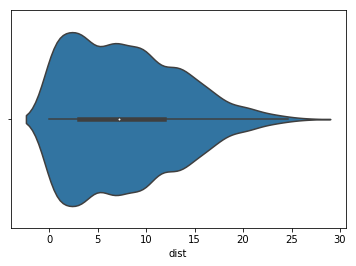

In [61]:
sns.violinplot(x=od_matrix.toPandas()["dist"])

In [ ]:
inference_ok = od_matrix.filter('distance < 1.0').count()/float(od_matrix.count())
print "Percentage of trips with destionation satisfying threshold: ", inference_ok

In [62]:
printdf(user_boardings.filter(((user_boardings.route == 916) & (user_boardings.tripNum == 8))) \
        .orderBy('timestamp'), l=100)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,userGender,date
0,916,8,2893,6068354,-25.400911,-49.330169,0.000,MA002,None,-25.400930,...,2.491781,13:09:59,33126,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
1,916,8,2273,4159067,-25.373298,-49.331735,198.390,MA007,None,NaN,...,NaN,13:12:07,33446,BETWEEN,None,None,None,NaN,None,2017-05-10
2,916,8,2273,4159080,-25.375819,-49.334449,589.579,MA007,None,-25.375781,...,4.504221,13:12:37,33443,NO_PROBLEM,None,None,None,NaN,None,2017-05-10
3,916,8,2273,4159088,-25.377074,-49.334534,768.393,MA007,None,-25.377118,...,14.073664,13:13:10,33436,NO_PROBLEM,None,13:13:31,PINHEIROS,10095128.0,,2017-05-10
4,916,8,2273,4159093,-25.378036,-49.333845,942.650,MA007,None,NaN,...,NaN,13:13:32,33433,BETWEEN,13/10/02,13:14:42,PINHEIROS,3789520.0,F,2017-05-10
5,916,8,2273,4159093,-25.378036,-49.333845,942.650,MA007,None,NaN,...,NaN,13:13:32,33433,BETWEEN,11/08/87,13:14:28,PINHEIROS,3473358.0,F,2017-05-10
6,916,8,2273,4159093,-25.378036,-49.333845,942.650,MA007,None,NaN,...,NaN,13:13:32,33433,BETWEEN,20/03/78,13:14:51,PINHEIROS,1349468.0,M,2017-05-10
7,916,8,2273,4159093,-25.378036,-49.333845,942.650,MA007,None,NaN,...,NaN,13:13:32,33433,BETWEEN,09/01/95,13:14:55,PINHEIROS,3668242.0,M,2017-05-10
8,916,8,2273,4159093,-25.378036,-49.333845,942.650,MA007,None,NaN,...,NaN,13:13:32,33433,BETWEEN,18/08/82,13:14:31,PINHEIROS,1275985.0,F,2017-05-10
9,916,8,2273,4159093,-25.378036,-49.333845,942.650,MA007,None,NaN,...,NaN,13:13:32,33433,BETWEEN,20/08/71,13:14:34,PINHEIROS,851402.0,M,2017-05-10
